In [31]:
!pip install tensorflow-hub
!pip install pillow


In [32]:
import functools
import os
import time
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from matplotlib import gridspec
import matplotlib.pylab as plt
from PIL import Image

print("TF Version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))


TF Version:  2.15.0
TF Hub version:  0.16.1
Eager mode enabled:  True
GPU available:  []


In [33]:
def crop_center(image):
    shape = image.shape
    new_shape = min(shape[1], shape[2])
    offset_y = max(shape[1] - shape[2], 0) // 2
    offset_x = max(shape[2] - shape[1], 0) // 2
    image = tf.image.crop_to_bounding_box(
        image, offset_y, offset_x, new_shape, new_shape)
    return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
    image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
    img = tf.io.decode_image(
        tf.io.read_file(image_path),
        channels=3, dtype=tf.float32)[tf.newaxis, ...]
    img = crop_center(img)
    img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
    return img

def show_n(images, titles=('',)):
    n = len(images)
    image_sizes = [image.shape[1] for image in images]
    w = (image_sizes[0] * 6) // 320
    plt.figure(figsize=(w * n, w))
    gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
    for i in range(n):
        plt.subplot(gs[i])
        plt.imshow(images[i][0], aspect='equal')
        plt.axis('off')
        plt.title(titles[i] if len(titles) > i else '')
    plt.show()


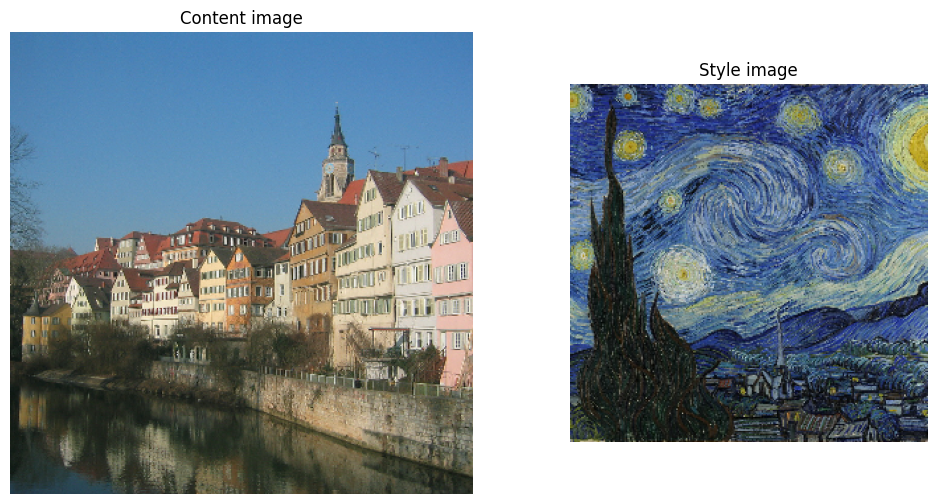

In [34]:
content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg'
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'
output_image_size = 350

content_img_size = (output_image_size, output_image_size)
style_img_size = (256, 256)  # VGG19 input size

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
show_n([content_image, style_image], ['Content image', 'Style image'])


In [35]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations


In [36]:
def extract_features(image):
    image = image * 255.0
    preprocessed_image = tf.keras.applications.vgg19.preprocess_input(image)
    style_outputs = style_extractor(preprocessed_image)
    content_outputs = content_extractor(preprocessed_image)

    style_features = [gram_matrix(style_output) for style_output in style_outputs]
    content_features = [content_output for content_output in content_outputs]
    return style_features, content_features

style_extractor = vgg_layers(style_layers)
content_extractor = vgg_layers(content_layers)

style_targets = extract_features(style_image)[0]
content_targets = extract_features(content_image)[1]


In [37]:
class StyleTransferModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleTransferModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.num_content_layers = len(content_layers)

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = outputs[:self.num_style_layers], outputs[self.num_style_layers:]

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

extractor = StyleTransferModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))
style_results = results['style']
content_results = results['content']


In [38]:
def style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[i])**2)
                           for i, name in enumerate(style_outputs.keys())])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[i])**2)
                             for i, name in enumerate(content_outputs.keys())])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss


Epoch 1 completed


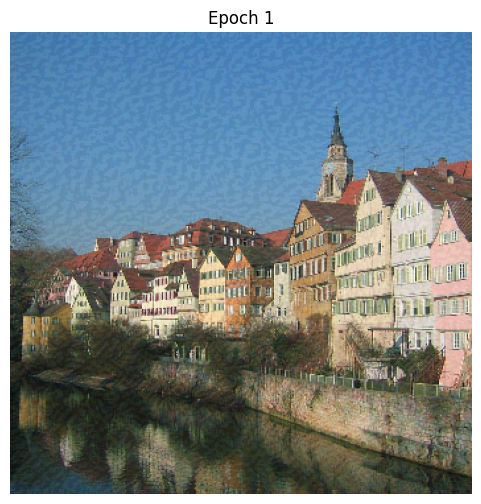

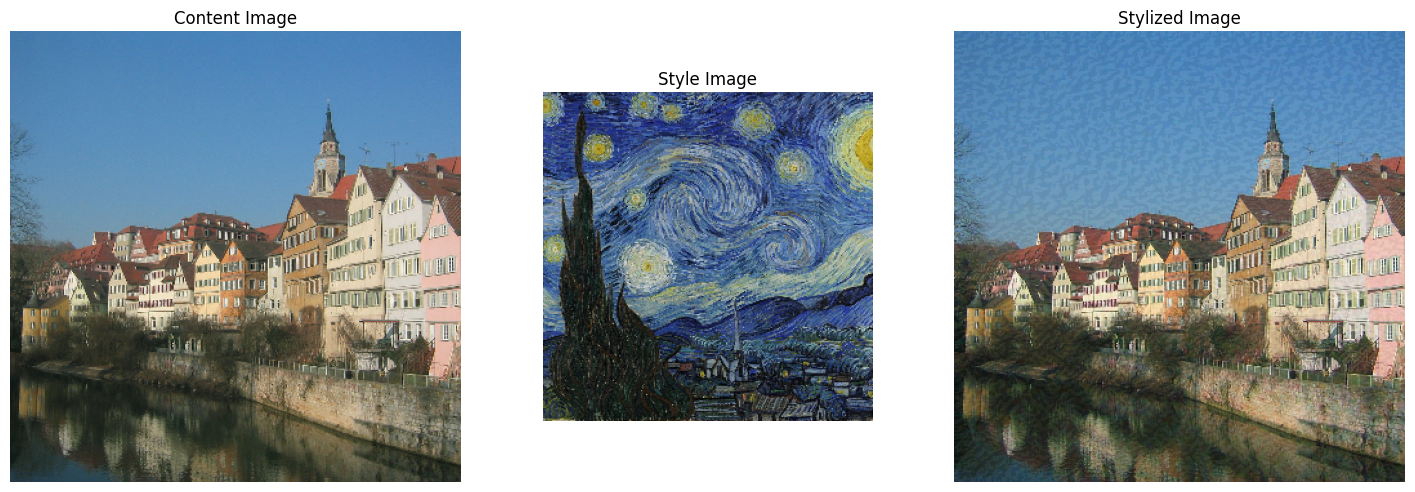

In [40]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight = 1e-2
content_weight = 1e4

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

image = tf.Variable(content_image)
epochs = 10
steps_per_epoch = 100

for n in range(epochs):
    for m in range(steps_per_epoch):
        train_step(image)
    print(f"Epoch {n+1} completed")
    show_n([image.read_value()], titles=[f'Epoch {n+1}'])

show_n([content_image, style_image, image.read_value()], titles=['Content Image', 'Style Image', 'Stylized Image'])
